# 1. Counting people crossed the line(door)

Method 1: Total people crossed: 7
Method 2: Pixel change graph


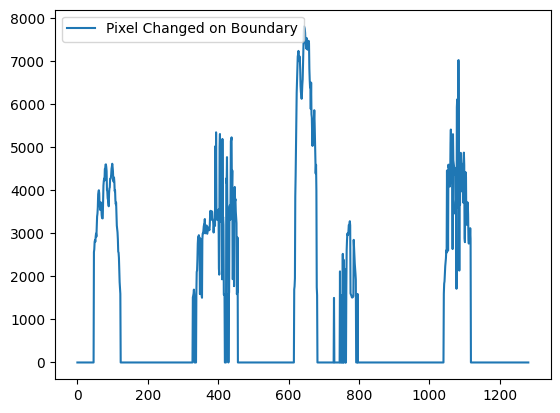

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Select video source (0 = webcam, or video = path "example.mp4")
video = cv2.VideoCapture("example.mp4")

# Read the first frame as the background
success, background = video.read()
if not success:
    print("Unable to read video or camera!")
    video.release()
    cv2.destroyAllWindows()
    exit()

# Get video dimensions
height, width = background.shape[:2]
line_position = int(height * 0.5)  # Define the counting line position

# Initialize counting variables
people_count = 0  # Number of people crossing the boundary
change_values = []  # Store pixel change values for the plot
crossed = False  # Status of a person crossing the line

# Convert background to float type for smoother updates
background = np.float32(background)

while True:
    # Read the next frame
    success, frame = video.read()
    if not success:
        break 

    # Convert frame to float for weighted averaging
    frame_float = frame.astype(np.float32)
    
    # Update the background using weighted averaging (alpha = 0.1)
    cv2.accumulateWeighted(frame_float, background, 0.1)
    
    # Convert the background back to uint8 format for display
    avg_display = cv2.convertScaleAbs(background)

    # Compute the difference between the current frame and the background
    diff = cv2.absdiff(frame, avg_display)
    
    # Create a binary mask to highlight moving objects
    foreground_mask = cv2.inRange(diff, (40, 40, 40), (255, 255, 255))

    # Apply morphological operations to reduce noise
    kernel = np.ones((7, 7), np.uint8)
    morph_mask = cv2.morphologyEx(foreground_mask, cv2.MORPH_CLOSE, kernel)

    # Detect moving objects
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(morph_mask)
    motion_pixels = 0  # Total pixel changes in the boundary region

    # Iterate through detected objects (excluding the background)
    for i in range(1, num_labels):  
        x, y, w, h, area = stats[i]  # Get bounding box and area of each object

        if area > 1500:  # Filter out small noise objects
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw a rectangle
            center_y = y + h // 2  # Calculate the object's center Y-coordinate
            motion_pixels += area  # Accumulate the area of moving pixels

            # Check if the object crosses the counting line
            if line_position - 2 < center_y < line_position + 2:
                if not crossed:
                    people_count += 1  # Increment count
                    crossed = True  # Mark that an object has crossed
            else:
                crossed = False  # Reset crossing status

    # Store pixel change values for plotting
    change_values.append(motion_pixels)

    # Draw the counting line
    cv2.line(frame, (0, line_position), (width, line_position), (0, 255, 255), 2)
    
    # Display the current count on the frame
    cv2.putText(frame, f"Count: {people_count}", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show the processed frames
    cv2.imshow("Frame", frame)
    cv2.imshow("Foreground Mask", morph_mask)

    # Exit the loop if the ESC key is pressed
    if cv2.waitKey(30) & 0xFF == 27:
        break

# Print the total count of people who crossed the line
print(f"Method 1: Total people crossed: {people_count}")
print(f"Method 2: Pixel change graph")

# Release video resources
video.release()
cv2.destroyAllWindows()

# Plot the pixel change values over time
plt.plot(change_values, label="Pixel Changed on Boundary")
plt.legend()
plt.show()


# Метод 1: Вычитание фона (Background Subtraction) для обнаружения движущихся объектов  
* Принцип: 
    Сравнивает каждый кадр с усреднённым фоном, чтобы выявить движущиеся объекты, затем проверяет, пересекает ли центр объекта границу.
* Полюсы:
    Может различать небольшие группы людей, если они идут на достаточном расстоянии друг от друга.
    Хорошо работает при небольшом количестве людей и разрозненном движении.
* Минусы:
    Зависит от порога обнаружения, размеров объектов и параметров фильтрации шумов.
    Может давать сбои при изменениях освещения или фона.
* Результат: 
    Определено 7 отдельных людей, так как программа пока не умеет различать двух людей, идущих вместе.

# Метод 2: Подсчёт изменения пикселей на границе
* Принцип: 
    Отслеживает изменение количества пикселей на границе во времени, чтобы определить момент прохождения человека (или группы людей).
* Полюсы:
    Эффективно работает при массовом прохождении людей.
    Меньше зависит от размеров и формы объектов.
* Минусы:
    Не позволяет точно подсчитать количество людей, а лишь фиксирует изменение пикселей.
* Результат:
    Определено 5 пересечений границы, так как метод учитывает только изменения пикселей и фиксирует количество групп людей, а не отдельных людей.

# 2. Seamless cloning

In [6]:
import cv2
import numpy as np

# Read images: 'src' image will be cloned into 'dst'
im = cv2.imread("background_Hanoi_autumn.jpg")  # Read the background image
obj = cv2.imread("obj.jpg")  # Read the object image to be inserted into the background

# Resize the background image 
im = cv2.resize(im, (3 * im.shape[1] // 4, 3 * im.shape[0] // 4))

# Resize the object image 
obj = cv2.resize(obj, (obj.shape[1] // 10, obj.shape[0] // 10))

# Print the dimensions of the background and object images
print(f"Background image (dst) size: {im.shape}")
print(f"Object image (src) size: {obj.shape}")

# Create an all-white mask of the same size as the object image
mask = 255 * np.ones(obj.shape, obj.dtype)

# The location of the center of the src in the dst (background)
#width, height, channels = im.shape
center = (580, 560)  # Set the position for the object to be inserted

# Seamlessly clone the object into the background with NORMAL_CLONE
normal_clone = cv2.seamlessClone(obj, im, mask, center, cv2.NORMAL_CLONE)

# Seamlessly clone the object into the background with MIXED_CLONE
mixed_clone = cv2.seamlessClone(obj, im, mask, center, cv2.MIXED_CLONE)

# Display the results for normal and mixed cloning
cv2.imshow("Seamless Clone", normal_clone)
cv2.imshow("Seamless Clone", mixed_clone)  # Show the mixed clone
cv2.waitKey(0)  # Wait for a key press to close the windows
cv2.destroyAllWindows()  # Close all OpenCV windows

# Save the results to disk
cv2.imwrite("images/opencv-normal-clone-example.jpg", normal_clone)  # Save normal clone result
cv2.imwrite("images/opencv-mixed-clone-example.jpg", mixed_clone)  # Save mixed clone result


Background image (dst) size: (898, 1350, 3)
Object image (src) size: (600, 400, 3)


False